In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
# Impostiamo gli hyperparametri
batch_size = 128
num_epoch = 100
z_dimension = 100  # dimensione del vettore di rumore in input al generatore

# Trasformazione delle immagini
def to_img(x):
    out = 0.5 * (x + 1)
    out = out.clamp(0, 1)
    out = out.view(-1, 1, 28, 28)
    return out

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Solita dataset ;)
dataset = datasets.MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                        num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 103340934.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66412112.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39499968.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21599238.97it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


# Definiamo la classe dei modelli nella GAN:
# Discriminatore
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),  # batch, 32, 28, 28
            nn.LeakyReLU(0.2, True),
            nn.AvgPool2d(2, stride=2),  # batch, 32, 14, 14
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),  # batch, 64, 14, 14
            nn.LeakyReLU(0.2, True),
            nn.AvgPool2d(2, stride=2)  # batch, 64, 7, 7
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        '''
        x: batch, width, height, channel=1
        '''
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Generatore
class Generator(nn.Module):
    def __init__(self, input_size, num_feature):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_size, num_feature)  # batch, 3136=1x56x56
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(True)
        )
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 50, 3, stride=1, padding=1),  # batch, 50, 56, 56
            nn.BatchNorm2d(50),
            nn.ReLU(True)
        )
        self.downsample2 = nn.Sequential(
            nn.Conv2d(50, 25, 3, stride=1, padding=1),  # batch, 25, 56, 56
            nn.BatchNorm2d(25),
            nn.ReLU(True)
        )
        self.downsample3 = nn.Sequential(
            nn.Conv2d(25, 1, 2, stride=2),  # batch, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1, 56, 56)
        x = self.br(x)
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        return x

In [5]:
# Creiamo un'istanza del Discriminatore
D = Discriminator().cuda()
# Creiamo un'istanza del Generatore
G = Generator(z_dimension, 3136).cuda()

# Definiamo la loss function
criterion = nn.BCELoss()

# Definiamo gli ottimizzatori per il discriminatore e il generatore
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [6]:
# Alleniamo le nostre reti
for epoch in range(num_epoch):
    for i, (img, _) in enumerate(dataloader):
        num_img = img.size(0)
        # Alleniamo il Discriminatore
        real_img = img.cuda()
        real_label = torch.ones(num_img).cuda()
        fake_label = torch.zeros(num_img).cuda()

        # Calcoliamo la loss del Discriminatore sulle immagini reali
        real_out = D(real_img).squeeze(1)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out  # Più è vicino a 1, meglio è

        # Calcoliamo la loss del Generatore sulle immagini generate
        z = torch.randn(num_img, z_dimension).cuda() # Noise di input
        fake_img = G(z)
        fake_out = D(fake_img).squeeze(1)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out  # Più è vicino a 0, meglio è

        # Ottimizzazione del Discriminatore
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Alleniamo il Generatore
        z = torch.randn(num_img, z_dimension).cuda()
        fake_img = G(z)
        output = D(fake_img).squeeze(1)
        # Calcoliamo la loss sulle immagini generate
        g_loss = criterion(output, real_label)

        # Ottimizzazione del Generatore
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
                  'D real: {:.6f}, D fake: {:.6f}'
                  .format(epoch, num_epoch, d_loss.item(), g_loss.item(),
                          real_scores.data.mean(), fake_scores.data.mean()))
    if epoch == 0:
        real_images = to_img(real_img.cpu().data)
        save_image(real_images, './dc_img/real_images.png')

    fake_images = to_img(fake_img.cpu().data)
    save_image(fake_images, './dc_img/fake_images-{}.png'.format(epoch+1))

torch.save(G.state_dict(), './generator.pth')
torch.save(D.state_dict(), './discriminator.pth')

Epoch [0/100], d_loss: 0.074068, g_loss: 4.207670 D real: 0.972226, D fake: 0.042586
Epoch [0/100], d_loss: 0.159671, g_loss: 2.670939 D real: 0.963213, D fake: 0.084873
Epoch [0/100], d_loss: 0.280190, g_loss: 2.973607 D real: 0.868864, D fake: 0.085278
Epoch [0/100], d_loss: 0.277497, g_loss: 2.203692 D real: 0.912877, D fake: 0.124297
Epoch [1/100], d_loss: 0.251448, g_loss: 5.094770 D real: 0.900604, D fake: 0.084302
Epoch [1/100], d_loss: 0.255685, g_loss: 3.344710 D real: 0.912017, D fake: 0.117409
Epoch [1/100], d_loss: 0.251149, g_loss: 4.998824 D real: 0.883562, D fake: 0.056648
Epoch [1/100], d_loss: 0.300308, g_loss: 3.435688 D real: 0.847314, D fake: 0.034931
Epoch [2/100], d_loss: 0.231808, g_loss: 3.218212 D real: 0.906606, D fake: 0.065317
Epoch [2/100], d_loss: 0.276669, g_loss: 2.508510 D real: 0.979805, D fake: 0.177980
Epoch [2/100], d_loss: 0.206957, g_loss: 3.655740 D real: 0.916674, D fake: 0.055750
Epoch [2/100], d_loss: 0.184745, g_loss: 3.903989 D real: 0.89534

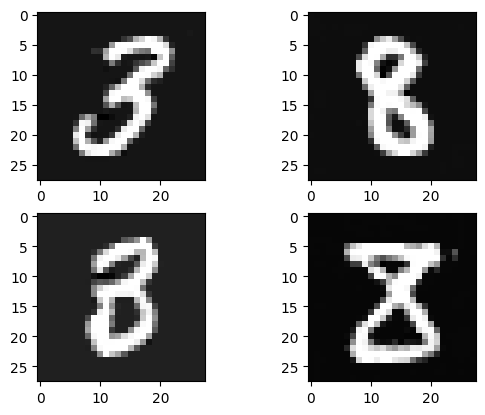

In [11]:
# Generiamo nuovi campioni
z = torch.randn(4, z_dimension).cuda()
fake_img = G(z)

# Guardiamo i campioni generati
plt.subplot(2,2,1)
plt.imshow(fake_img.detach().cpu()[0][0], cmap="gray")
plt.subplot(2,2,2)
plt.imshow(fake_img.detach().cpu()[1][0], cmap="gray")
plt.subplot(2,2,3)
plt.imshow(fake_img.detach().cpu()[2][0], cmap="gray")
plt.subplot(2,2,4)
plt.imshow(fake_img.detach().cpu()[3][0], cmap="gray")

In [8]:
fake_img.shape

torch.Size([1, 1, 28, 28])